## Fichier Jupyter conçu pour lire un fichier CSV existant et visualiser ses données.


--- Lancement de l'analyse pour le fichier : '../joblib/Cristian/dataset_entrainement_knn_cristian.csv' ---
✅ Fichier '../joblib/Cristian/dataset_entrainement_knn_cristian.csv' chargé. Dimensions : (114, 12)
   -> Nombre de lignes dans votre fichier : 114
🧹 1 ligne(s) avec des valeurs manquantes ont été supprimées.
🔬 Caractéristiques mises à l'échelle (StandardScaler).
   -> Nombre de points à visualiser : 113

⏳ Calcul de la PCA...
   -> Nombre de points pour le graphique PCA : 113


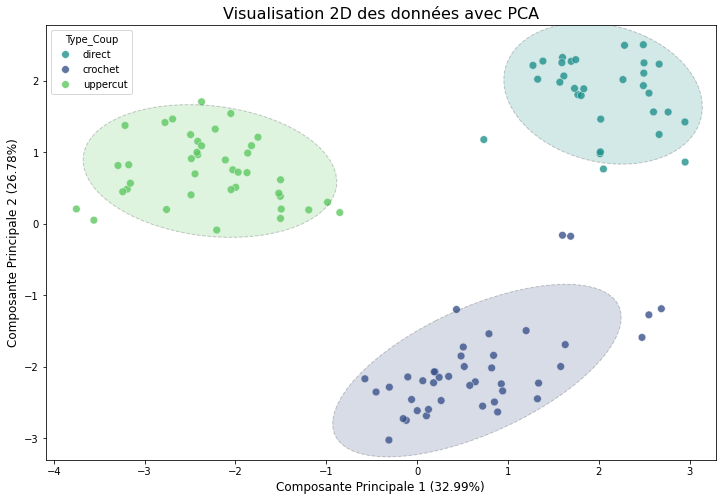


⏳ Calcul de la t-SNE (cela peut prendre du temps)...


C:\Users\laptop\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


   -> Nombre de points pour le graphique t-SNE : 113


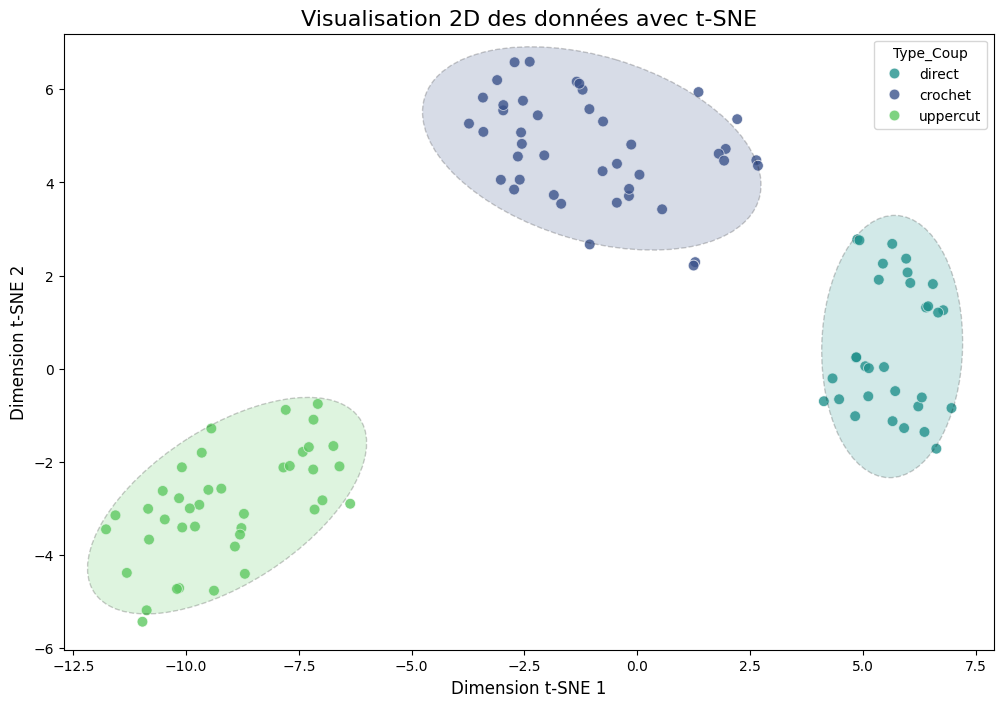

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms



def plot_confidence_ellipse(data, ax, n_std=2.0, **kwargs):
    if data.shape[0] < 2:
        return
    cov = np.cov(data, rowvar=False)
    mean = np.mean(data, axis=0)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    vx, vy = eigvecs[:, 0][0], eigvecs[:, 0][1]
    theta = np.degrees(np.arctan2(vy, vx))
    width, height = 2 * n_std * np.sqrt(eigvals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ellipse)


def visualiser_features_2d(file_path):
    # --- 1. Définition des colonnes à extraire du CSV ---
    feature_columns = [
        'Min_AccX_Val', 'Max_AccX_Val', 'AccX_Amplitude', 'AccX_Ord(1=Max>Min)',
        'Min_AccZ_Val', 'Max_Roll_Val', 'Min_Roll_Val', 'Roll_Ord(1=Max>Min)',
        'Max_Pitch_Val', 'Min_Pitch_Val', 'Pitch_Ord(1=Max>Min)'
    ]
    target_column = 'Type_Coup'

    # --- 2. Chargement et validation des données du fichier ---
    try:
        df = pd.read_csv(file_path)
        print(f"✅ Fichier '{file_path}' chargé. Dimensions : {df.shape}")
        # VÉRIFICATION : Nombre de lignes initiales
        print(f"   -> Nombre de lignes dans votre fichier : {len(df)}")
    except FileNotFoundError:
        print(f"❌ ERREUR : Le fichier '{file_path}' est introuvable.")
        return

    required_columns = feature_columns + [target_column]
    if not all(col in df.columns for col in required_columns):
        print(f"❌ ERREUR : Colonnes manquantes : {', '.join([c for c in required_columns if c not in df.columns])}")
        return

    # --- 3. Préparation des données chargées ---
    df_cleaned = df[required_columns].dropna()
    rows_dropped = len(df) - len(df_cleaned)
    if rows_dropped > 0:
        print(f"🧹 {rows_dropped} ligne(s) avec des valeurs manquantes ont été supprimées.")

    X = df_cleaned[feature_columns]
    y = df_cleaned[target_column]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("🔬 Caractéristiques mises à l'échelle (StandardScaler).")
    # VÉRIFICATION 2 : Nombre de points qui seront réellement utilisés
    print(f"   -> Nombre de points à visualiser : {len(X_scaled)}")


    # --- 4. Visualisation PCA des données ---
    print("\n⏳ Calcul de la PCA...")
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    df_pca[target_column] = y.values
    
    # VÉRIFICATION 3 : Nombre de points dans le DataFrame pour le graphique PCA
    print(f"   -> Nombre de points pour le graphique PCA : {len(df_pca)}")

    
    #plt.style.use('seaborn-whitegrid')
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(12, 8))
    
    unique_labels = sorted(df_pca[target_column].unique())
    palette = sns.color_palette('viridis', n_colors=len(unique_labels))
    color_map = dict(zip(unique_labels, palette))

    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue=target_column, palette=color_map, s=60, alpha=0.8, ax=ax)

    for name, group in df_pca.groupby(target_column):
        plot_confidence_ellipse(group[['PC1', 'PC2']].values, ax, facecolor=color_map[name], alpha=0.2, edgecolor='black', linestyle='--')
    
    variance_ratio = pca.explained_variance_ratio_
    ax.set_title('Visualisation 2D des données avec PCA', fontsize=16)
    ax.set_xlabel(f'Composante Principale 1 ({variance_ratio[0]:.2%})', fontsize=12)
    ax.set_ylabel(f'Composante Principale 2 ({variance_ratio[1]:.2%})', fontsize=12)
    ax.legend(title=target_column)
    plt.show()

    # --- 5. Visualisation t-SNE des données ---
    print("\n⏳ Calcul de la t-SNE (cela peut prendre du temps)...")
    perplexity_val = min(30, len(X_scaled) - 1)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_val, n_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)
    df_tsne = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne[target_column] = y.values

    # VÉRIFICATION 4 : Nombre de points dans le DataFrame pour le graphique t-SNE
    print(f"   -> Nombre de points pour le graphique t-SNE : {len(df_tsne)}")

    
    #plt.style.use('seaborn-whitegrid')
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(12, 8))
    
    sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue=target_column, palette=color_map, s=60, alpha=0.8, ax=ax)

    for name, group in df_tsne.groupby(target_column):
        plot_confidence_ellipse(group[['TSNE1', 'TSNE2']].values, ax, facecolor=color_map[name], alpha=0.2, edgecolor='black', linestyle='--')

    ax.set_title('Visualisation 2D des données avec t-SNE', fontsize=16)
    ax.set_xlabel('Dimension t-SNE 1', fontsize=12)
    ax.set_ylabel('Dimension t-SNE 2', fontsize=12)
    ax.legend(title=target_column)
    plt.show()


if __name__ == '__main__':

    NOM_DU_FICHIER_CSV = "../joblib/Cristian/dataset_entrainement_knn_cristian.csv" 

    # 2. Lancement de l'analyse
    print(f"--- Lancement de l'analyse pour le fichier : '{NOM_DU_FICHIER_CSV}' ---")
    visualiser_features_2d(NOM_DU_FICHIER_CSV)